In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Conv1D, MaxPool1D, Conv2D, MaxPool2D, Flatten
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, f1_score
from itertools import cycle
from sklearn.preprocessing import OneHotEncoder

# Limited Power Mode

In [2]:
classes = {'F0L.csv':0, 'F1L.csv':1, 'F2L.csv':2, 'F3L.csv':3, 'F4L.csv':4, 'F5L.csv':5, 'F6L.csv':6, 'F7L.csv':7}
timesteps = 20
x_train = list()
y_train = list()
x_test = list()
y_test = list()
y_class = list()
x_val = list()
y_val = list()
for class_name, class_label in classes.items():
    data = pd.read_csv(class_name).dropna()
    data.set_index('Time', inplace=True)
    print(data.shape)
    data_scaled = StandardScaler().fit_transform(data)
    dim_1 = data_scaled.shape[0]//20
    for i in range(0, dim_1-1000):
        x_train.append(data_scaled[i*timesteps:(i+1)*timesteps])
        y_train.append(class_label)
    for i in range(dim_1-1000, dim_1-500):
        x_val.append(data_scaled[i*timesteps:(i+1)*timesteps])
        y_val.append(class_label)
    for i in range(dim_1-500, dim_1):
        x_test.append(data_scaled[i*timesteps:(i+1)*timesteps])
        y_test.append(class_label)
        y_class.append(class_name)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_train.shape, x_test.shape, x_val.shape, y_val.shape, y_train.shape, y_test.shape

(143715, 13)
(129013, 13)
(142128, 13)
(103497, 13)
(144014, 13)
(143015, 13)
(144015, 13)
(144015, 13)


((46665, 20, 13), (4000, 20, 13), (4000, 20, 13), (4000,), (46665,), (4000,))

In [3]:
array = np.array(y_class)
array = array.reshape(-1,1)
array.shape
df = pd.DataFrame(array, columns=['class'])
enc = OneHotEncoder()
y_encoded = pd.DataFrame(enc.fit_transform( 
    np.array(df['class']).reshape(-1,1)).toarray())
y_encoded = np.array(y_encoded)

# Model1

In [ ]:
model1 = Sequential([
    Conv1D(32, input_shape=(x_train.shape[1] ,x_train.shape[2]), padding='same', kernel_size=(3), activation='relu'),
    Conv1D(64, padding='same', kernel_size=3),
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(32, activation='relu',return_sequences=False),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='softmax')
])
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_val, y_val))

In [ ]:
model1.save("LSTM_fault_prediction.h5")
print("Saved model to disk")

In [ ]:
model1.save_weights('LSTM_weights.h5')

In [4]:
model1 = models.load_model('LSTM_fault_prediction.h5', compile=False)
print("Model is loaded")
model1.load_weights('LSTM_weights.h5')

Model is loaded


In [5]:
y_pred = model1.predict(x_test)
y_pred_classes = [np.argmax(i) for i in y_pred]
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_classes)

0.84375

In [6]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm

array([[445,   0,   0,   0,   4,   0,   3,  48],
       [  0, 500,   0,   0,   0,   0,   0,   0],
       [  0,   0, 498,   0,   1,   1,   0,   0],
       [  0, 389,   0,   0,   0,  16,  90,   5],
       [ 15,   0,   2,   1, 472,   0,   2,   8],
       [  0,   0,   0,   0,   0, 500,   0,   0],
       [  0,   1,   0,   0,   0,   1, 475,  23],
       [  6,   0,   0,   0,   4,   0,   5, 485]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted label')

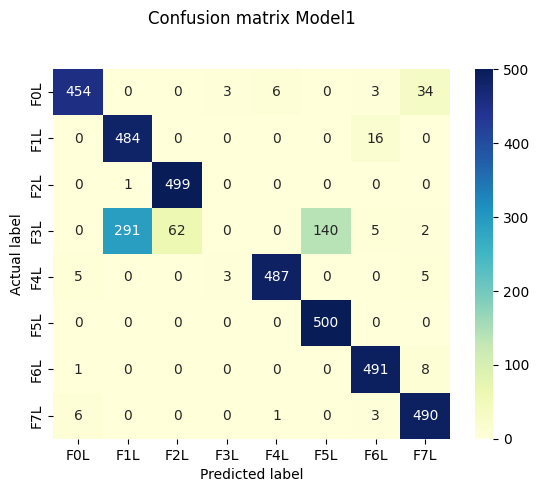

In [10]:
target_names = ['F0L', 'F1L', 'F2L', 'F3L', 'F4L', 'F5L', 'F6L', 'F7L']
p = sns.heatmap(pd.DataFrame(cm), annot=True, xticklabels=target_names, yticklabels=target_names, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix Model1', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

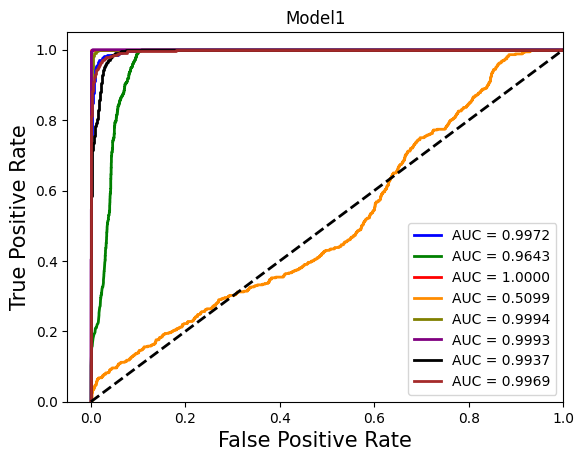

In [10]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors =cycle(['blue', 'green', 'red','darkorange','olive','purple','black', 'brown'])
for i, color in zip(range(8), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='AUC = {1:0.4f}'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
# plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.title('Model1')
plt.show()

In [11]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       500
           1       0.56      1.00      0.72       500
           2       1.00      1.00      1.00       500
           3       0.00      0.00      0.00       500
           4       0.98      0.94      0.96       500
           5       0.97      1.00      0.98       500
           6       0.83      0.95      0.88       500
           7       0.85      0.97      0.91       500

    accuracy                           0.84      4000
   macro avg       0.77      0.84      0.80      4000
weighted avg       0.77      0.84      0.80      4000



# Model2

In [ ]:
model2 = Sequential([
    LSTM(16, input_shape=(x_train.shape[1] ,x_train.shape[2]), activation='relu', return_sequences=True),
    LSTM(32, activation='relu',return_sequences=True),
    LSTM(64, activation='relu',return_sequences=False),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(8, activation='softmax')
])
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model2.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val))

In [ ]:
model2.save("LSTM_fault_prediction.h5")
print("Saved model to disk")
model2.save_weights('LSTM_weights.h5')

In [7]:
model2 = models.load_model('LSTM2_fault_prediction.h5', compile=False)
print("Model is loaded")
model2.load_weights('LSTM2_weights.h5')

Model is loaded


In [8]:
y_pred_2 = model2.predict(x_test)
y_pred_classes_2 = [np.argmax(i) for i in y_pred_2]
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_classes_2)

0.85125

Text(0.5, 23.52222222222222, 'Predicted label')

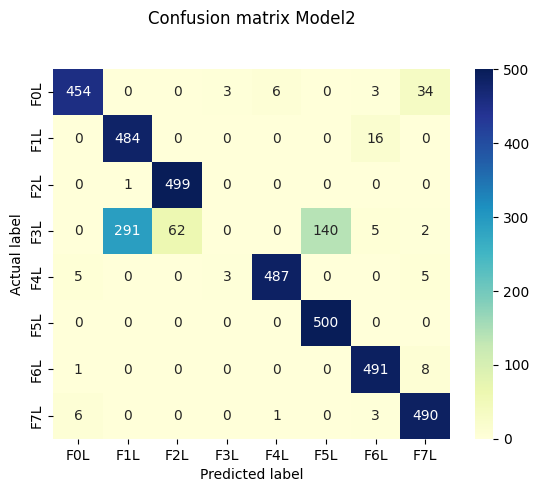

In [11]:
cm = confusion_matrix(y_test, y_pred_classes_2)
cm
p = sns.heatmap(pd.DataFrame(cm), annot=True, xticklabels=target_names, yticklabels=target_names, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix Model2', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

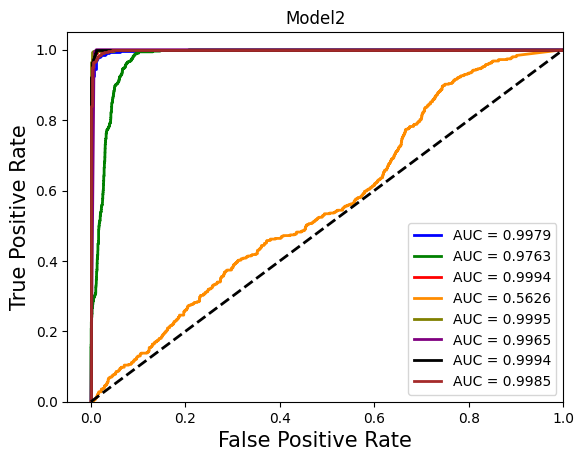

In [14]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:, i], y_pred_2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors =cycle(['blue', 'green', 'red','darkorange','olive','purple','black', 'brown'])
for i, color in zip(range(8), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='AUC = {1:0.4f}'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
# plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.title('Model2')
plt.show()

In [15]:
print(classification_report(y_test, y_pred_classes_2))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       500
           1       0.62      0.97      0.76       500
           2       0.89      1.00      0.94       500
           3       0.00      0.00      0.00       500
           4       0.99      0.97      0.98       500
           5       0.78      1.00      0.88       500
           6       0.95      0.98      0.96       500
           7       0.91      0.98      0.94       500

    accuracy                           0.85      4000
   macro avg       0.76      0.85      0.80      4000
weighted avg       0.76      0.85      0.80      4000



# High Power Mode

In [12]:
classes_2 = {'F0M.csv':0, 'F1M.csv':1, 'F2M.csv':2, 'F3M.csv':3, 'F4M.csv':4, 'F5M.csv':5, 'F6M.csv':6, 'F7M.csv':7}
timesteps = 20
x_train_2 = list()
y_train_2 = list()
x_test_2 = list()
y_test_2 = list()
y_class_2 = list()
x_val_2 = list()
y_val_2 = list()
for class_name, class_label in classes_2.items():
    data = pd.read_csv(class_name).dropna()
    data.set_index('Time', inplace=True)
    print(data.shape)
    data_scaled = StandardScaler().fit_transform(data)
    dim_1 = data_scaled.shape[0]//20
    for i in range(0, dim_1-1000):
        x_train_2.append(data_scaled[i*timesteps:(i+1)*timesteps])
        y_train_2.append(class_label)
    for i in range(dim_1-1000, dim_1-500):
        x_val_2.append(data_scaled[i*timesteps:(i+1)*timesteps])
        y_val_2.append(class_label)
    for i in range(dim_1-500, dim_1):
        x_test_2.append(data_scaled[i*timesteps:(i+1)*timesteps])
        y_test_2.append(class_label)
        y_class_2.append(class_name)
x_train_2 = np.array(x_train_2)
y_train_2 = np.array(y_train_2)
x_test_2 = np.array(x_test_2)
y_test_2 = np.array(y_test_2)
x_val_2 = np.array(x_val_2)
y_val_2 = np.array(y_val_2)
x_train_2.shape, x_test_2.shape, x_val_2.shape, y_val_2.shape, y_train_2.shape, y_test_2.shape

(141014, 13)
(139014, 13)
(144015, 13)
(69967, 13)
(144014, 13)
(144014, 13)
(144015, 13)
(144015, 13)


((45498, 20, 13), (4000, 20, 13), (4000, 20, 13), (4000,), (45498,), (4000,))

In [13]:
array2 = np.array(y_class_2)
array2 = array2.reshape(-1,1)
array2.shape
df_2 = pd.DataFrame(array2, columns=['class'])
enc = OneHotEncoder()
y_encoded_2 = pd.DataFrame(enc.fit_transform( 
    np.array(df_2['class']).reshape(-1,1)).toarray())
y_encoded_2 = np.array(y_encoded_2)

# Model3

In [145]:
model3 = Sequential([
    Conv1D(32, input_shape=(x_train_2.shape[1] ,x_train_2.shape[2]), padding='same', kernel_size=(3), activation='relu'),
    Conv1D(64, padding='same', kernel_size=3),
    LSTM(16, activation='tanh', return_sequences=True),
    LSTM(32, activation='tanh',return_sequences=True),
    LSTM(64, activation='tanh',return_sequences=False),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='softmax')
])
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.fit(x_train_2, y_train_2, epochs=30, batch_size=128, validation_data=(x_val_2, y_val_2))

Epoch 1/30
356/356 [==============================] - 9s 17ms/step - loss: 1.2650 - accuracy: 0.4862 - val_loss: 1.5573 - val_accuracy: 0.3728
Epoch 2/30
356/356 [==============================] - 5s 14ms/step - loss: 0.8096 - accuracy: 0.6552 - val_loss: 1.2319 - val_accuracy: 0.4775
Epoch 3/30
356/356 [==============================] - 5s 14ms/step - loss: 0.6796 - accuracy: 0.7117 - val_loss: 0.9037 - val_accuracy: 0.6083
Epoch 4/30
356/356 [==============================] - 5s 15ms/step - loss: 0.5690 - accuracy: 0.7680 - val_loss: 0.6855 - val_accuracy: 0.7387
Epoch 5/30
356/356 [==============================] - 5s 14ms/step - loss: 0.4641 - accuracy: 0.8154 - val_loss: 0.7114 - val_accuracy: 0.7435
Epoch 6/30
356/356 [==============================] - 5s 14ms/step - loss: 0.3882 - accuracy: 0.8460 - val_loss: 0.8352 - val_accuracy: 0.7527
Epoch 7/30
356/356 [==============================] - 5s 14ms/step - loss: 0.3507 - accuracy: 0.8628 - val_loss: 0.4516 - val_accuracy: 0.8320

In [146]:
y_pred_3 = model3.predict(x_test_2)
y_pred_classes_3 = [np.argmax(i) for i in y_pred_3]
from sklearn.metrics import accuracy_score
accuracy_score(y_test_2, y_pred_classes_3)

0.836

In [147]:
model3.save("LSTM3_fault_prediction.h5")
print("Saved model to disk")
model3.save_weights('LSTM3_weights.h5')

Saved model to disk


In [14]:
model3 = models.load_model('LSTM3_fault_prediction.h5', compile=False)
print("Model is loaded")
model3.load_weights('LSTM3_weights.h5')

Model is loaded


In [15]:
y_pred_3 = model3.predict(x_test_2)
y_pred_classes_3 = [np.argmax(i) for i in y_pred_3]
from sklearn.metrics import accuracy_score
accuracy_score(y_test_2, y_pred_classes_3)

0.836

In [16]:
cm = confusion_matrix(y_test_2, y_pred_classes_3)
cm

array([[453,   0,   0,   0,   7,   0,  35,   5],
       [  0, 410,   0,   0,  27,  43,   0,  20],
       [  0,   0, 498,   0,   0,   0,   1,   1],
       [ 61,  34,   0, 370,   0,   5,  22,   8],
       [  9,   0,   0,   0, 481,   0,   8,   2],
       [  0,   0,  65,   0,   0, 435,   0,   0],
       [ 31,   0,   0,   0,   7,   0, 223, 239],
       [ 14,   0,   0,   0,   5,   0,   7, 474]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted label')

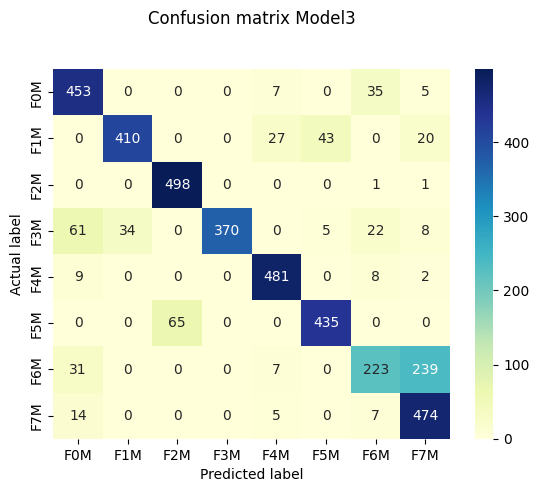

In [17]:
target_names_2 = ['F0M', 'F1M', 'F2M', 'F3M', 'F4M', 'F5M', 'F6M', 'F7M']
p = sns.heatmap(pd.DataFrame(cm), annot=True, xticklabels=target_names_2, yticklabels=target_names_2, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix Model3', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

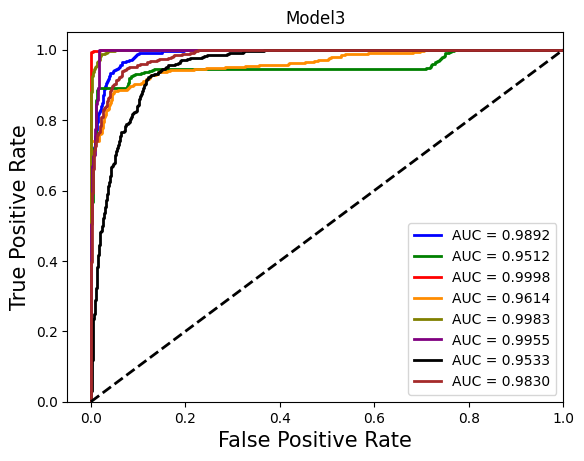

In [17]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_encoded_2[:, i], y_pred_3[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors =cycle(['blue', 'green', 'red','darkorange','olive','purple','black', 'brown'])
for i, color in zip(range(8), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='AUC = {1:0.4f}'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
# plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.title('Model3')
plt.show()

In [18]:
print(classification_report(y_test_2, y_pred_classes_3))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       500
           1       0.92      0.82      0.87       500
           2       0.88      1.00      0.94       500
           3       1.00      0.74      0.85       500
           4       0.91      0.96      0.94       500
           5       0.90      0.87      0.89       500
           6       0.75      0.45      0.56       500
           7       0.63      0.95      0.76       500

    accuracy                           0.84      4000
   macro avg       0.85      0.84      0.83      4000
weighted avg       0.85      0.84      0.83      4000



# Model4

In [ ]:
model4 = Sequential([
    LSTM(16, input_shape=(x_train_2.shape[1] ,x_train_2.shape[2]), activation='tanh', return_sequences=True),
    LSTM(32, activation='tanh',return_sequences=True),
    LSTM(64, activation='tanh',return_sequences=False),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(8, activation='softmax')
])
model4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model4.fit(x_train_2, y_train_2, epochs=100, batch_size=128, validation_data=(x_val_2, y_val_2))

In [ ]:
y_pred_4 = model4.predict(x_test_2)
y_pred_classes_4 = [np.argmax(i) for i in y_pred_4]
from sklearn.metrics import accuracy_score
accuracy_score(y_test_2, y_pred_classes_4)

In [ ]:
model4.save("LSTM4_fault_prediction.h5")
print("Saved model to disk")
model4.save_weights('LSTM4_weights.h5')

In [34]:
model4 = models.load_model('LSTM4_fault_prediction.h5', compile=False)
print("Model is loaded")
model4.load_weights('LSTM4_weights.h5')

Model is loaded


In [35]:
y_pred_4 = model4.predict(x_test_2)
y_pred_classes_4 = [np.argmax(i) for i in y_pred_4]
from sklearn.metrics import accuracy_score
accuracy_score(y_test_2, y_pred_classes_4)

0.82925

In [36]:
cm = confusion_matrix(y_test_2, y_pred_classes_4)
cm

array([[483,   0,   0,   2,   2,   0,   8,   5],
       [  0, 444,   0,   0,   0,  56,   0,   0],
       [  0,   0, 500,   0,   0,   0,   0,   0],
       [ 21,   1,   5, 372,  88,   0,   0,  13],
       [  5,   0,   0,   3, 487,   0,   1,   4],
       [  0,  75, 107,   0,   0, 318,   0,   0],
       [  2,   0,   0,   0,   3,   0, 226, 269],
       [  1,   0,   0,   0,   0,   0,  12, 487]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted label')

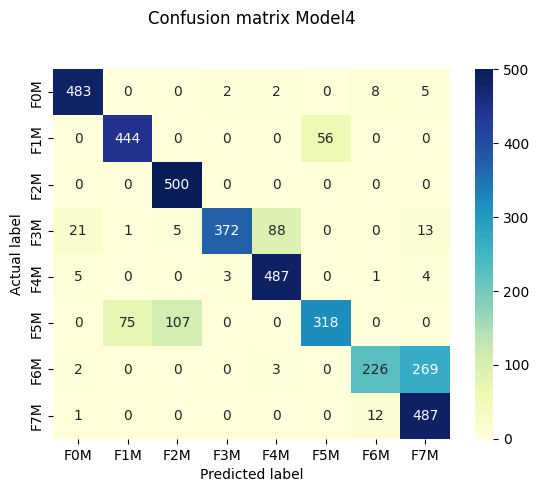

In [37]:
p = sns.heatmap(pd.DataFrame(cm), annot=True, xticklabels=target_names_2, yticklabels=target_names_2, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix Model4', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

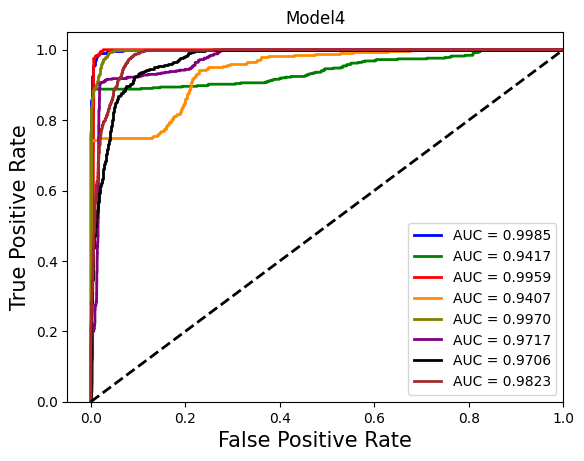

In [27]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_encoded_2[:, i], y_pred_4[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors =cycle(['blue', 'green', 'red','darkorange','olive','purple','black', 'brown'])
for i, color in zip(range(8), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='AUC = {1:0.4f}'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
# plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.title('Model4')
plt.show()

In [26]:
print(classification_report(y_test_2, y_pred_classes_4))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       500
           1       0.85      0.89      0.87       500
           2       0.82      1.00      0.90       500
           3       0.99      0.74      0.85       500
           4       0.84      0.97      0.90       500
           5       0.85      0.64      0.73       500
           6       0.91      0.45      0.61       500
           7       0.63      0.97      0.76       500

    accuracy                           0.83      4000
   macro avg       0.85      0.83      0.82      4000
weighted avg       0.85      0.83      0.82      4000

